# Crime and Voting Behavior Analysis

In this project we analyze the relationship between crime rates and voting behavior in the netherlands.

## Data Sources
- CBS Crime Statistics (83648NED)
- Dutch Election Results (2012, 2017, 2021, 2023)

### Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm

from linearmodels.panel import PanelOLS, FirstDifferenceOLS
from libpysal.weights import W
from spreg import ML_Lag, GM_Lag


### Configuration

In [2]:
# Directory confeguration
DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'


RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Election years
ELECTION_YEARS = [2010, 2012, 2017, 2021, 2023]

# CBS Crime data configuration (download these from the like above and extract the file into data/raw. https://datasets.cbs.nl/CSV/CBS/nl/83648NED)
CBS_DATASET_ID = '83648NED'
CRIME_MEASURE = 'M004200_2'  # Total registered crimes
CRIME_RATE = 'M004200_4'
TOTAL_CRIME_TYPE = 'T001161'  # Total cime

PARTY_NAME_TO_CODE = {}
GEMEENTE_TO_PROVINCE = {
    # Drenthe
    "Aa en Hunze": "Drenthe", "Assen": "Drenthe", "Borger-Odoorn": "Drenthe",
    "Coevorden": "Drenthe", "Emmen": "Drenthe", "Hoogeveen": "Drenthe",
    "Meppel": "Drenthe", "Midden-Drenthe": "Drenthe", "Noordenveld": "Drenthe",
    "Tynaarlo": "Drenthe", "Westerveld": "Drenthe", "De Wolden": "Drenthe",

    # Flevoland
    "Almere": "Flevoland", "Dronten": "Flevoland", "Lelystad": "Flevoland",
    "Noordoostpolder": "Flevoland", "Urk": "Flevoland", "Zeewolde": "Flevoland",

    # Friesland
    "Achtkarspelen": "Friesland", "Ameland": "Friesland", "Dantumadeel": "Friesland",
    "De Friese Meren": "Friesland", "Harlingen": "Friesland", "Heerenveen": "Friesland",
    "Leeuwarden": "Friesland", "Noardeast-Friesland": "Friesland",
    "Ooststellingwerf": "Friesland", "Opsterland": "Friesland",
    "Schiermonnikoog": "Friesland", "Smallingerland": "Friesland",
    "Súdwest-Friesland": "Friesland", "Terschelling": "Friesland",
    "Tietjerksteradeel": "Friesland", "Vlieland": "Friesland",
    "Waadhoeke": "Friesland", "Weststellingwerf": "Friesland",

    # Gelderland
    "Aalten": "Gelderland", "Apeldoorn": "Gelderland", "Arnhem": "Gelderland",
    "Barneveld": "Gelderland", "Berg en Dal": "Gelderland",
    "Berkelland": "Gelderland", "Beuningen": "Gelderland",
    "Bronckhorst": "Gelderland", "Brummen": "Gelderland", "Buren": "Gelderland",
    "Culemborg": "Gelderland", "Doesburg": "Gelderland", "Doetinchem": "Gelderland",
    "Druten": "Gelderland", "Duiven": "Gelderland", "Ede": "Gelderland",
    "Elburg": "Gelderland", "Epe": "Gelderland", "Ermelo": "Gelderland",
    "Harderwijk": "Gelderland", "Hattem": "Gelderland", "Heerde": "Gelderland",
    "Heumen": "Gelderland", "Lingewaard": "Gelderland", "Lochem": "Gelderland",
    "Maasdriel": "Gelderland", "Montferland": "Gelderland",
    "Neder-Betuwe": "Gelderland", "Nijkerk": "Gelderland", "Nijmegen": "Gelderland",
    "Nunspeet": "Gelderland", "Oldebroek": "Gelderland",
    "Oost Gelre": "Gelderland", "Oude IJsselstreek": "Gelderland",
    "Overbetuwe": "Gelderland", "Putten": "Gelderland", "Renkum": "Gelderland",
    "Rheden": "Gelderland", "Rozendaal": "Gelderland",
    "Scherpenzeel": "Gelderland", "Tiel": "Gelderland", "Voorst": "Gelderland",
    "Wageningen": "Gelderland", "West Betuwe": "Gelderland",
    "West Maas en Waal": "Gelderland", "Westervoort": "Gelderland",
    "Wijchen": "Gelderland", "Winterswijk": "Gelderland",
    "Zaltbommel": "Gelderland", "Zevenaar": "Gelderland", "Zutphen": "Gelderland",

    # Groningen
    "Eemsdelta": "Groningen", "Groningen": "Groningen",
    "Het Hogeland": "Groningen", "Midden-Groningen": "Groningen",
    "Oldambt": "Groningen", "Pekela": "Groningen", "Stadskanaal": "Groningen",
    "Veendam": "Groningen", "Westerkwartier": "Groningen",
    "Westerwolde": "Groningen",

    # Limburg
    "Beek": "Limburg", "Beekdaelen": "Limburg", "Beesel": "Limburg",
    "Bergen": "Limburg", "Brunssum": "Limburg", "Echt-Susteren": "Limburg",
    "Eijsden-Margraten": "Limburg", "Gennep": "Limburg",
    "Gulpen-Wittem": "Limburg", "Heerlen": "Limburg",
    "Horst aan de Maas": "Limburg", "Kerkrade": "Limburg",
    "Landgraaf": "Limburg", "Leudal": "Limburg", "Maasgouw": "Limburg",
    "Maastricht": "Limburg", "Meerssen": "Limburg",
    "Mook en Middelaar": "Limburg", "Nederweert": "Limburg",
    "Peel en Maas": "Limburg", "Roerdalen": "Limburg",
    "Roermond": "Limburg", "Simpelveld": "Limburg",
    "Sittard-Geleen": "Limburg", "Stein": "Limburg",
    "Vaals": "Limburg", "Valkenburg aan de Geul": "Limburg",
    "Venlo": "Limburg", "Venray": "Limburg", "Voerendaal": "Limburg",
    "Weert": "Limburg",

    # Noord-Brabant
    "Alphen-Chaam": "Noord-Brabant", "Altena": "Noord-Brabant",
    "Asten": "Noord-Brabant", "Baarle-Nassau": "Noord-Brabant",
    "Bergeijk": "Noord-Brabant", "Bergen op Zoom": "Noord-Brabant",
    "Bernheze": "Noord-Brabant", "Best": "Noord-Brabant",
    "Bladel": "Noord-Brabant", "Boekel": "Noord-Brabant",
    "Boxtel": "Noord-Brabant", "Breda": "Noord-Brabant",
    "Cranendonck": "Noord-Brabant", "Deurne": "Noord-Brabant",
    "Dongen": "Noord-Brabant", "Drimmelen": "Noord-Brabant",
    "Eersel": "Noord-Brabant", "Eindhoven": "Noord-Brabant",
    "Etten-Leur": "Noord-Brabant", "Geertruidenberg": "Noord-Brabant",
    "Geldrop-Mierlo": "Noord-Brabant", "Gemert-Bakel": "Noord-Brabant",
    "Gilze en Rijen": "Noord-Brabant", "Goirle": "Noord-Brabant",
    "Halderberge": "Noord-Brabant", "Heeze-Leende": "Noord-Brabant",
    "Helmond": "Noord-Brabant", "'s-Hertogenbosch": "Noord-Brabant",
    "Heusden": "Noord-Brabant", "Hilvarenbeek": "Noord-Brabant",
    "Laarbeek": "Noord-Brabant", "Land van Cuijk": "Noord-Brabant",
    "Loon op Zand": "Noord-Brabant", "Maashorst": "Noord-Brabant",
    "Meierijstad": "Noord-Brabant", "Moerdijk": "Noord-Brabant",
    "Nuenen c.a.": "Noord-Brabant", "Oirschot": "Noord-Brabant",
    "Oisterwijk": "Noord-Brabant", "Oosterhout": "Noord-Brabant",
    "Oss": "Noord-Brabant", "Reusel-De Mierden": "Noord-Brabant",
    "Roosendaal": "Noord-Brabant", "Rucphen": "Noord-Brabant",
    "Sint-Michielsgestel": "Noord-Brabant", "Someren": "Noord-Brabant",
    "Son en Breugel": "Noord-Brabant", "Steenbergen": "Noord-Brabant",
    "Tilburg": "Noord-Brabant", "Valkenswaard": "Noord-Brabant",
    "Veldhoven": "Noord-Brabant", "Vught": "Noord-Brabant",
    "Waalre": "Noord-Brabant", "Waalwijk": "Noord-Brabant",
    "Woensdrecht": "Noord-Brabant", "Zundert": "Noord-Brabant",

    # Noord-Holland
    "Aalsmeer": "Noord-Holland", "Alkmaar": "Noord-Holland",
    "Amstelveen": "Noord-Holland", "Amsterdam": "Noord-Holland",
    "Bergen": "Noord-Holland", "Beverwijk": "Noord-Holland",
    "Blaricum": "Noord-Holland", "Bloemendaal": "Noord-Holland",
    "Castricum": "Noord-Holland", "'s-Gravenhage": "Noord-Holland",
    "Diemen": "Noord-Holland", "Dijk en Waard": "Noord-Holland",
    "Drechterland": "Noord-Holland", "Edam-Volendam": "Noord-Holland",
    "Enkhuizen": "Noord-Holland", "Gooise Meren": "Noord-Holland",
    "Haarlem": "Noord-Holland", "Haarlemmermeer": "Noord-Holland",
    "Heemskerk": "Noord-Holland", "Heemstede": "Noord-Holland",
    "Heiloo": "Noord-Holland", "Hilversum": "Noord-Holland",
    "Hollands Kroon": "Noord-Holland", "Hoorn": "Noord-Holland",
    "Huizen": "Noord-Holland", "Koggenland": "Noord-Holland",
    "Landsmeer": "Noord-Holland", "Laren": "Noord-Holland",
    "Medemblik": "Noord-Holland", "Oostzaan": "Noord-Holland",
    "Opmeer": "Noord-Holland", "Ouder-Amstel": "Noord-Holland",
    "Purmerend": "Noord-Holland", "Schagen": "Noord-Holland",
    "Stede Broec": "Noord-Holland", "Texel": "Noord-Holland",
    "Uitgeest": "Noord-Holland", "Uithoorn": "Noord-Holland",
    "Velsen": "Noord-Holland", "Waterland": "Noord-Holland",
    "Wijdemeren": "Noord-Holland", "Wormerland": "Noord-Holland",
    "Zaanstad": "Noord-Holland", "Zandvoort": "Noord-Holland",

    # Overijssel
    "Almelo": "Overijssel", "Borne": "Overijssel", "Dalfsen": "Overijssel",
    "Deventer": "Overijssel", "Dinkelland": "Overijssel",
    "Enschede": "Overijssel", "Haaksbergen": "Overijssel",
    "Hardenberg": "Overijssel", "Hellendoorn": "Overijssel",
    "Hengelo": "Overijssel", "Hof van Twente": "Overijssel",
    "Kampen": "Overijssel", "Losser": "Overijssel",
    "Oldenzaal": "Overijssel", "Olst-Wijhe": "Overijssel",
    "Ommen": "Overijssel", "Raalte": "Overijssel",
    "Rijssen-Holten": "Overijssel", "Staphorst": "Overijssel",
    "Steenwijkerland": "Overijssel", "Tubbergen": "Overijssel",
    "Twenterand": "Overijssel", "Wierden": "Overijssel",
    "Zwartewaterland": "Overijssel", "Zwolle": "Overijssel",

    # Utrecht
    "Amersfoort": "Utrecht", "Baarn": "Utrecht", "De Bilt": "Utrecht",
    "Bunnik": "Utrecht", "Bunschoten": "Utrecht", "Eemnes": "Utrecht",
    "Houten": "Utrecht", "IJsselstein": "Utrecht", "Leusden": "Utrecht",
    "Lopik": "Utrecht", "Montfoort": "Utrecht", "Nieuwegein": "Utrecht",
    "Oudewater": "Utrecht", "Renswoude": "Utrecht", "Rhenen": "Utrecht",
    "De Ronde Venen": "Utrecht", "Soest": "Utrecht",
    "Stichtse Vecht": "Utrecht", "Utrecht": "Utrecht",
    "Utrechtse Heuvelrug": "Utrecht", "Veenendaal": "Utrecht",
    "Vijfheerenlanden": "Utrecht", "Wijk bij Duurstede": "Utrecht",
    "Woerden": "Utrecht", "Woudenberg": "Utrecht", "Zeist": "Utrecht",

    # Zeeland
    "Borsele": "Zeeland", "Goes": "Zeeland", "Hulst": "Zeeland",
    "Kapelle": "Zeeland", "Middelburg": "Zeeland",
    "Noord-Beveland": "Zeeland", "Reimerswaal": "Zeeland",
    "Schouwen-Duiveland": "Zeeland", "Sluis": "Zeeland",
    "Terneuzen": "Zeeland", "Tholen": "Zeeland", "Veere": "Zeeland",
    "Vlissingen": "Zeeland",

    # Zuid-Holland
    "Alblasserdam": "Zuid-Holland", "Albrandswaard": "Zuid-Holland",
    "Alphen aan den Rijn": "Zuid-Holland", "Barendrecht": "Zuid-Holland",
    "Bodegraven-Reeuwijk": "Zuid-Holland", "Capelle aan den IJssel": "Zuid-Holland",
    "Delft": "Zuid-Holland", "'s-Gravenhage": "Zuid-Holland",
    "Dordrecht": "Zuid-Holland", "Goeree-Overflakkee": "Zuid-Holland",
    "Gorinchem": "Zuid-Holland", "Gouda": "Zuid-Holland",
    "Hardinxveld-Giessendam": "Zuid-Holland", "Hendrik-Ido-Ambacht": "Zuid-Holland",
    "Hillegom": "Zuid-Holland", "Hoeksche Waard": "Zuid-Holland",
    "Kaag en Braassem": "Zuid-Holland", "Katwijk": "Zuid-Holland",
    "Krimpen aan den IJssel": "Zuid-Holland", "Krimpenerwaard": "Zuid-Holland",
    "Lansingerland": "Zuid-Holland", "Leiden": "Zuid-Holland",
    "Leiderdorp": "Zuid-Holland", "Leidschendam-Voorburg": "Zuid-Holland",
    "Lisse": "Zuid-Holland", "Maassluis": "Zuid-Holland",
    "Midden-Delfland": "Zuid-Holland", "Molenlanden": "Zuid-Holland",
    "Nieuwkoop": "Zuid-Holland", "Nissewaard": "Zuid-Holland",
    "Noordwijk": "Zuid-Holland", "Oegstgeest": "Zuid-Holland",
    "Papendrecht": "Zuid-Holland", "Pijnacker-Nootdorp": "Zuid-Holland",
    "Ridderkerk": "Zuid-Holland", "Rijswijk": "Zuid-Holland",
    "Rotterdam": "Zuid-Holland", "Schiedam": "Zuid-Holland",
    "Sliedrecht": "Zuid-Holland", "Teylingen": "Zuid-Holland",
    "Vlaardingen": "Zuid-Holland", "Voorne aan Zee": "Zuid-Holland",
    "Voorschoten": "Zuid-Holland", "Waddinxveen": "Zuid-Holland",
    "Wassenaar": "Zuid-Holland", "Westland": "Zuid-Holland",
    "Zoetermeer": "Zuid-Holland", "Zoeterwoude": "Zuid-Holland",
    "Zuidplas": "Zuid-Holland", "Zwijndrecht": "Zuid-Holland"
}


In [3]:
# Custom styling for matplotlib
# Set matplotlib rcParams for consistent styling, these act global, until overwriten somewhere.
plt.rcParams.update({
    'figure.facecolor': '#f5f5f5',
    'axes.facecolor': '#f5f5f5',
    'legend.facecolor': '#f5f5f5'
})

### Data Loading Functions

In [4]:
def load_cbs_metadata(data_dir):
    metadata = {}
    files = {
        'measures': 'MeasureCodes.csv',
        'regions': 'RegioSCodes.csv',
        'periods': 'PeriodenCodes.csv',
        'crime_types': 'SoortMisdrijfCodes.csv'
    }

    for key, filename in files.items():
        filepath = data_dir / filename
        try:
            metadata[key] = pd.read_csv(filepath, sep=';', encoding='utf-8',  decimal=",")
        except Exception as e:
            print(f"{key}, {filename}: {e}")
    return metadata


def load_cbs_observations(data_dir):
    filepath = data_dir / 'Observations.csv'

    try:
        df = pd.read_csv(filepath, sep=';', encoding='utf-8', on_bad_lines='skip',  decimal=",")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None


def load_election_data(data_dir, years=None):
    if years is None:
        years = ELECTION_YEARS

    all_elections = []

    for year in years:
        pattern = f"uitslag_TK{year}*_Gemeente.csv"
        files = list(data_dir.glob(pattern))

        if not files:
            print(f"No election data found for {year}")
            continue

        filepath = files[0]

        try:
            df = pd.read_csv(filepath, sep=';', encoding='utf-8',  decimal=",")
            df['Year'] = year
            all_elections.append(df)
        except Exception as e:
            print(f"Error loading {year}: {e}")

    combined = pd.concat(all_elections, ignore_index=True)
    return combined


### Data Processing Functions

In [5]:
def process_crime_data(df, metadata=None):
    # Filter for total registered crimes measure

    df = df[df['SoortMisdrijf'] == TOTAL_CRIME_TYPE].copy()

    # (M004200_2)
    df_crime_total = df[df['Measure'] == CRIME_MEASURE].copy()
    df_crime_total['Value'] = pd.to_numeric(df_crime_total['Value'])
    # (M004200_4)
    df_crime_rate = df[df['Measure'] == CRIME_RATE].copy()
    df_crime_rate['Value'] = pd.to_numeric(df_crime_rate['Value'])

    # Extract year from period code (format: YYYYJJxx)
    df_crime_total['Year'] = df_crime_total['Perioden'].str[:4].astype(int)
    df_crime_rate['Year'] = df_crime_rate['Perioden'].str[:4].astype(int)
    
    # Group by region and year, sum values
    crime_total = df_crime_total.groupby(['RegioS', 'Year'])['Value'].sum().reset_index()
    crime_total.columns = ['Region_Code', 'Year', 'Total_Crimes']
    
    # Group by region and year, sum values for crime rate
    crime_rate = df_crime_rate.groupby(['RegioS', 'Year'])['Value'].sum().reset_index()
    crime_rate.columns = ['Region_Code', 'Year', 'Crime_Rate']
    
    # Merge the two datasets on Region_Code and Year
    crime_by_region = crime_total.merge(
        crime_rate,
        on=['Region_Code', 'Year'],
        how='outer'
    )
    # Remove missing values
    crime_by_region = crime_by_region.dropna()

    # Merge with region metadata if available
    if metadata and metadata.get('regions') is not None:
        regions = metadata['regions'][['Identifier', 'Title']].copy()
        regions.columns = ['Region_Code', 'Region_Name']
        crime_by_region = crime_by_region.merge(regions, on='Region_Code', how='left')

    # Separate provincial and municipal data
    crime_provincial = crime_by_region[crime_by_region['Region_Code'].str.startswith('PV', na=False)].copy()
    crime_municipal = crime_by_region[crime_by_region['Region_Code'].str.startswith('GM', na=False)].copy()

    # Remove the ' (PV)' at the end of Region_Name
    crime_provincial['Region_Name'] = crime_provincial['Region_Name'].str[:-5]

    return crime_provincial, crime_municipal


def process_election_data(df):
    if df is None or len(df) == 0:
        print("No election data to process")
        return None

    df = df.copy()
    # Drop unwanted columns
    # AmsterdamseCode;AantalZetels;Unnamed: 6
    df = df.drop(columns=[col for col in ['AmsterdamseCode', 'AantalZetels', 'Unnamed: 6'] if col in df.columns], errors='ignore')

    rename_map = {
        'Code': 'Region_Code',
        'Gemeente': 'Region_Name',
        'Partij': 'Party',
        'AantalStemmen': 'Votes',
        'Jaar': 'Year',
    }

    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # Calculate seats at national level
    party_national_votes = df.groupby(['Party', 'Year'])['Votes'].sum().reset_index()
    party_national_votes.columns = ['Party', 'Year', 'National_Votes']

    # The total votes cast in that election
    total_votes_per_year = party_national_votes.groupby('Year')['National_Votes'].sum().reset_index()
    total_votes_per_year.columns = ['Year', 'Total_Votes_Cast']

    party_national_votes = party_national_votes.merge(total_votes_per_year, on='Year')

    # This isn't totally the right way to do it but it gets us far enough, we dont care about seats, but we just want to remove irrelavant parties.
    party_national_votes['Votes_Per_Seat'] = party_national_votes['Total_Votes_Cast'] / 150
    party_national_votes['Seats'] = np.floor(
        party_national_votes['National_Votes'] / party_national_votes['Votes_Per_Seat']
    ).astype(int)

    # Count elections where party had at least 1 seat
    party_elections_with_seats = party_national_votes[party_national_votes['Seats'] > 0].groupby('Party')['Year'].nunique().reset_index()
    party_elections_with_seats.columns = ['Party', 'Elections_With_Seats']

    # Keep parties with seats in 2+ elections
    parties_to_keep = party_elections_with_seats[
        party_elections_with_seats['Elections_With_Seats'] >= 2
    ]['Party'].tolist()

    # Exception: GroenLinks/PvdA
    if 'GroenLinks-PvdA' in party_national_votes['Party'].values:
        if 'GroenLinks-PvdA' not in parties_to_keep:
            parties_to_keep.append('GroenLinks-PvdA')

    # Filter the seat calculation data
    party_national_votes = party_national_votes[party_national_votes['Party'].isin(parties_to_keep)]

    df = df.merge(
        party_national_votes[['Party', 'Year', 'Seats']],
        on=['Party', 'Year'],
        how='left'
    )

    # Apply filter to main dataframe
    df = df[df['Party'].isin(parties_to_keep)].copy()

    # Calculate vote shares per region-year
    if 'Votes' in df.columns:
        total_votes = df.groupby(['Region_Code', 'Year'])['Votes'].transform('sum')
        df['Vote_Share'] = (df['Votes'] / total_votes) * 100

    return df


def separate_regional_municipal_votes(df, municipality_to_province=GEMEENTE_TO_PROVINCE):
    if df is None or len(df) == 0:
        return None, None

    municipal = df.copy()
    municipal['Region_Code'] = 'GM' + municipal['Region_Code'].str[1:]

    # For provincial data, we need to aggregate municipal votes by province
    # First, map municipality names to provinces
    df['Province'] = df['Region_Name'].map(municipality_to_province)

    # Remove rows where we couldn't map to a province
    df_with_province = df[df['Province'].notna()].copy()

    # Aggregate votes by province, party, and year
    provincial = df_with_province.groupby(['Province', 'Party', 'Year']).agg({
        'Votes': 'sum',
        'Seats': 'first'  # Seats are calculated at national level, so just take first value
    }).reset_index()

    total_votes = provincial['Votes'].sum()
    provincial['Vote_Share'] = provincial['Votes']/total_votes * 100
    # Rename Province to Region_Name for consistency
    provincial = provincial.rename(columns={'Province': 'Region_Name'})

    # Create provincial Region_Code
    province_codes = {
        'Drenthe': 'PV20',
        'Friesland': 'PV21', # Fryslan, I don't know a way to type the hat on linux
        'Groningen': 'PV22',
        'Overijssel': 'PV23',
        'Flevoland': 'PV24',
        'Gelderland': 'PV25',
        'Utrecht': 'PV26',
        'Noord-Holland': 'PV27',
        'Zuid-Holland': 'PV28',
        'Zeeland': 'PV29',
        'Noord-Brabant': 'PV30',
        'Limburg': 'PV31'
    }

    provincial['Region_Code'] = provincial['Region_Name'].map(province_codes)
    return provincial, municipal

### Load and Process Data

In [6]:
# Load or process data
# First check if all processed files exist
crime_provincial_file = PROCESSED_DIR / 'crime_provincial.csv'
crime_municipal_file = PROCESSED_DIR / 'crime_municipal.csv'
votes_provincial_file = PROCESSED_DIR / 'panel_votes_provincial.csv'
votes_municipal_file = PROCESSED_DIR / 'votes_municipal.csv'

all_processed_exist = all([
    crime_provincial_file.exists(),
    crime_municipal_file.exists(),
    votes_provincial_file.exists(),
    votes_municipal_file.exists()
])

if all_processed_exist:
    print("Loading processed data files...")
    panel_crime_municipal = pd.read_csv(crime_municipal_file)
    panel_crime_provincial = pd.read_csv(crime_provincial_file)
    panel_votes_municipal = pd.read_csv(votes_municipal_file)
    panel_votes_provincial = pd.read_csv(votes_provincial_file)
    print("All processed data loaded successfully!")
else:
    print("Processed files not found. Loading and processing raw data...")
    
    # Load metadata
    print("Loading CBS metadata...")
    metadata = load_cbs_metadata(RAW_DIR)
    
    # Load crime data
    print("Loading CBS crime data...")
    crime_obs = load_cbs_observations(RAW_DIR)
    
    # Load election data
    print("Loading election data...")
    elections_raw = load_election_data(RAW_DIR)
    
    # Process crime data
    if crime_obs is not None and metadata is not None:
        print("Processing crime data...")
        panel_crime_provincial, panel_crime_municipal = process_crime_data(crime_obs, metadata)
        
        # Save processed crime data
        panel_crime_provincial.to_csv(crime_provincial_file, index=False)
        panel_crime_municipal.to_csv(crime_municipal_file, index=False)
        print('Crime data processed and saved.')
    else:
        print('ERROR: No crime data found to process')
    
    # Process election data
    if elections_raw is not None:
        print("Processing election data...")
        elections_processed = process_election_data(elections_raw)
        
        # Separate into provincial and municipal
        panel_votes_provincial, panel_votes_municipal = separate_regional_municipal_votes(elections_processed)
        
        # Save processed election data
        if panel_votes_provincial is not None:
            panel_votes_provincial.to_csv(votes_provincial_file, index=False)
        if panel_votes_municipal is not None:
            panel_votes_municipal.to_csv(votes_municipal_file, index=False)
        print('Election data processed and saved.')
    else:
        print('ERROR: No election data found to process')
    
    print("\nAll data processing complete!")

Loading processed data files...
All processed data loaded successfully!


## Code by Kaai
subquestion 1 work

"To what extent do changes in regional crime rates predict shifts in electoral support for political parties in the Netherlands?"

In [7]:
panel = pd.merge(
    panel_votes_municipal,
    panel_crime_municipal,
    on=["Region_Code", "Year", "Region_Name"],
    how="inner"   # keep only municipality-years present in both
)

The following is a Fixed Effects Regression model.
This model uses the change of crime within a municipality to check if that influences voting share, when crime is higher then the average, does this influence the share of votes some parties get? By looking only within municipalities themselfs, we eliminate factors like culture, geography and more. These would be stable charsaristics that could still influence crime.
A con of this model is it assumes a linear relationship.

In [8]:
# Running model 1 for all parties
parties_to_analyze = panel['Party'].unique().tolist()
results_levels_all = []

for party_name in parties_to_analyze:
    party_data = panel[panel["Party"] == party_name].copy()
    party_data = party_data.dropna(subset=['Vote_Share', 'Crime_Rate'])
    
    if len(party_data) < 10:  # need at least some data
        continue
    
    party_data = party_data.set_index(["Region_Code", "Year"])
    y = party_data["Vote_Share"]
    X = sm.add_constant(party_data[["Crime_Rate"]])
    
    try:
        model_fe_levels = PanelOLS(y, X, entity_effects=True, time_effects=True)
        results_fe_levels = model_fe_levels.fit(cov_type="clustered", cluster_entity=True)
        
        coef = results_fe_levels.params['Crime_Rate']
        se = results_fe_levels.std_errors['Crime_Rate']
        pval = results_fe_levels.pvalues['Crime_Rate']
        
        results_levels_all.append({
            'Party': party_name,
            'Coefficient': coef,
            'Std_Error': se,
            'P-value': pval,
            'Significant': '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else '',
            'R_squared': results_fe_levels.rsquared
        })
    except:
        continue

results_levels_df = pd.DataFrame(results_levels_all)
results_levels_df = results_levels_df.sort_values('Coefficient', ascending=False)
print(results_levels_df[['Party', 'Coefficient', 'Std_Error', 'P-value', 'Significant', 'R_squared']].to_string(index=False))

                                 Party  Coefficient  Std_Error      P-value Significant  R_squared
       Partij van de Arbeid (P.v.d.A.)     0.113178   0.019858 1.549749e-08         ***   0.066363
                 Forum voor Democratie     0.021248   0.011009 5.402649e-02           *   0.009246
                                  JA21     0.018975   0.011437 9.807149e-02           *   0.015273
         PVV (Partij voor de Vrijheid)     0.012688   0.027112 6.398807e-01               0.001376
                                  Volt     0.011599   0.006020 5.490132e-02           *   0.030520
            SP (Socialistische Partij)     0.009981   0.008760 2.547438e-01               0.001961
Staatkundig Gereformeerde Partij (SGP)     0.009671   0.004396 2.798051e-02          **   0.005792
                                50PLUS     0.008338   0.003000 5.547056e-03         ***   0.010444
                                  DENK     0.003530   0.006685 5.976320e-01               0.000574
          

This model does almost the same, but instead of looking at the level of crime we look at the change in crime. So instead of seeing of high crime municipalities vote different, we look to see if voting changes when crime changes.

In [9]:
# Create the lagged and change variables
panel["Crime_Rate_Lag"] = panel.groupby(["Party", "Region_Code"])["Crime_Rate"].shift(1)
panel["Vote_Share_Lag"] = panel.groupby(["Party", "Region_Code"])["Vote_Share"].shift(1)
panel["Vote_Share_Change"] = panel.groupby(["Party", "Region_Code"])["Vote_Share"].diff()
panel["Crime_Rate_Change"] = panel.groupby(["Party", "Region_Code"])["Crime_Rate"].diff()

# Running model 2 for all parties
results_changes_all = []

for party_name in parties_to_analyze:
    party_data_changes = panel[panel["Party"] == party_name].copy()
    party_data_changes = party_data_changes.dropna(subset=['Vote_Share_Change', 'Crime_Rate_Change'])
    
    if len(party_data_changes) < 10:  # need enough observations
        continue
    
    party_data_changes = party_data_changes.set_index(["Region_Code", "Year"])
    y_change = party_data_changes["Vote_Share_Change"]
    X_change = sm.add_constant(party_data_changes[["Crime_Rate_Change"]])
    
    try:
        model_fe_changes = PanelOLS(y_change, X_change, entity_effects=True, time_effects=True)
        results_fe_changes = model_fe_changes.fit(cov_type="clustered", cluster_entity=True)
        
        coef = results_fe_changes.params['Crime_Rate_Change']
        se = results_fe_changes.std_errors['Crime_Rate_Change']
        pval = results_fe_changes.pvalues['Crime_Rate_Change']
        
        results_changes_all.append({
            'Party': party_name,
            'Coefficient': coef,
            'Std_Error': se,
            'P-value': pval,
            'Significant': '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else '',
            'R_squared': results_fe_changes.rsquared
        })
    except:
        continue

results_changes_df = pd.DataFrame(results_changes_all)
results_changes_df = results_changes_df.sort_values('Coefficient', ascending=False)
print(results_changes_df[['Party', 'Coefficient', 'Std_Error', 'P-value', 'Significant', 'R_squared']].to_string(index=False))

                                 Party  Coefficient  Std_Error  P-value Significant  R_squared
       Partij van de Arbeid (P.v.d.A.)     0.057874   0.036544 0.113729               0.008708
                                  DENK     0.057200   0.011819 0.000002         ***   0.301959
                 Forum voor Democratie     0.048527   0.023637 0.040912          **   0.029879
                                   VVD     0.045020   0.020375 0.027365          **   0.007755
                                   CDA     0.044296   0.019632 0.024748          **   0.014460
            SP (Socialistische Partij)     0.022005   0.011072 0.047144          **   0.007075
                          ChristenUnie     0.011892   0.003175 0.000190         ***   0.015058
                                50PLUS     0.004091   0.004904 0.404515               0.001495
                 Partij voor de Dieren    -0.005877   0.002495 0.018694          **   0.010669
                   Democraten 66 (D66)    -0.00946

The next model uses both the previous models to determine the relationship between crime and voting behaviour. It takes the original model, and then subtracts the previous model period. This way we eliminate all time invariance.

In [10]:
# Running model 3 (first difference) for all parties
results_fd_all = []

for party_name in parties_to_analyze:
    party_data_changes = panel[panel["Party"] == party_name].copy()
    party_data_changes = party_data_changes.dropna(subset=['Vote_Share_Change', 'Crime_Rate_Change'])
    
    if len(party_data_changes) < 10:
        continue
    
    party_data_changes = party_data_changes.set_index(["Region_Code", "Year"])
    y_fd = party_data_changes["Vote_Share_Change"]
    X_fd = party_data_changes[["Crime_Rate_Change"]]
    
    try:
        model_fd = FirstDifferenceOLS(y_fd, X_fd)
        results_fd = model_fd.fit(cov_type="clustered", cluster_entity=True)
        
        coef = results_fd.params['Crime_Rate_Change']
        se = results_fd.std_errors['Crime_Rate_Change']
        pval = results_fd.pvalues['Crime_Rate_Change']
        
        results_fd_all.append({
            'Party': party_name,
            'Coefficient': coef,
            'Std_Error': se,
            'P-value': pval,
            'Significant': '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else '',
            'R_squared': results_fd.rsquared
        })
    except:
        continue

results_fd_df = pd.DataFrame(results_fd_all)
results_fd_df = results_fd_df.sort_values('Coefficient', ascending=False)
print(results_fd_df[['Party', 'Coefficient', 'Std_Error', 'P-value', 'Significant', 'R_squared']].to_string(index=False))

                                 Party  Coefficient  Std_Error      P-value Significant  R_squared
       Partij van de Arbeid (P.v.d.A.)     1.037713   0.027354 0.000000e+00         ***   0.691091
                                   VVD     0.446522   0.016787 0.000000e+00         ***   0.451235
                                  DENK     0.075263   0.008878 8.881784e-16         ***   0.317101
Staatkundig Gereformeerde Partij (SGP)     0.004613   0.001300 4.053518e-04         ***   0.004670
                          ChristenUnie    -0.012894   0.001369 0.000000e+00         ***   0.043275
                 Partij voor de Dieren    -0.026266   0.001441 0.000000e+00         ***   0.155559
                                   CDA    -0.043729   0.019366 2.464042e-02          **   0.007695
            SP (Socialistische Partij)    -0.070759   0.007628 0.000000e+00         ***   0.135144
                 Forum voor Democratie    -0.123752   0.035398 5.412296e-04         ***   0.027831
          

The next model looks at the lagged effect, where yesterdays crime and voting affects todays voting behaviour. Kinda like asking.

In [11]:
# Running model 4 (lagged effects) for all parties
results_lag_all = []

for party_name in parties_to_analyze:
    party_data_lagged = panel[panel["Party"] == party_name].copy()
    party_data_lagged = party_data_lagged.dropna(subset=['Vote_Share', 'Crime_Rate_Lag', 'Vote_Share_Lag'])
    
    if len(party_data_lagged) < 10:
        continue
    
    party_data_lagged = party_data_lagged.set_index(["Region_Code", "Year"])
    y_lag = party_data_lagged["Vote_Share"]
    X_lag = sm.add_constant(party_data_lagged[["Crime_Rate_Lag", "Vote_Share_Lag"]])
    
    try:
        model_lag = PanelOLS(y_lag, X_lag, entity_effects=True)
        results_lag = model_lag.fit(cov_type="clustered", cluster_entity=True)
        
        coef_crime = results_lag.params['Crime_Rate_Lag']
        se_crime = results_lag.std_errors['Crime_Rate_Lag']
        pval_crime = results_lag.pvalues['Crime_Rate_Lag']
        
        coef_vote = results_lag.params['Vote_Share_Lag']
        se_vote = results_lag.std_errors['Vote_Share_Lag']
        pval_vote = results_lag.pvalues['Vote_Share_Lag']
        
        results_lag_all.append({
            'Party': party_name,
            'Crime_Coef': coef_crime,
            'Crime_SE': se_crime,
            'Crime_Sig': '***' if pval_crime < 0.01 else '**' if pval_crime < 0.05 else '*' if pval_crime < 0.10 else '',
            'Vote_Coef': coef_vote,
            'Vote_SE': se_vote,
            'Vote_Sig': '***' if pval_vote < 0.01 else '**' if pval_vote < 0.05 else '*' if pval_vote < 0.10 else '',
            'R_squared': results_lag.rsquared
        })
    except:
        continue

results_lag_df = pd.DataFrame(results_lag_all)
results_lag_df = results_lag_df.sort_values('Crime_Coef', ascending=False)
print(results_lag_df[['Party', 'Crime_Coef', 'Crime_SE', 'Crime_Sig', 'Vote_Coef', 'Vote_SE', 'Vote_Sig', 'R_squared']].to_string(index=False))

                                 Party  Crime_Coef  Crime_SE Crime_Sig  Vote_Coef  Vote_SE Vote_Sig  R_squared
       Partij van de Arbeid (P.v.d.A.)    0.994210  0.036728       ***  -0.887255 0.044705      ***   0.461096
                                   VVD    0.120374  0.009772       ***  -0.487173 0.018015      ***   0.388119
            SP (Socialistische Partij)    0.117280  0.006914       ***   0.623885 0.031076      ***   0.667436
                                50PLUS    0.104463  0.003768       ***   0.003003 0.014898            0.735117
                          ChristenUnie    0.013810  0.002350       ***   0.849400 0.186200      ***   0.241484
                                   CDA    0.000395  0.025049             1.681876 0.058796      ***   0.798967
                 Partij voor de Dieren   -0.005747  0.002557        **   0.422205 0.037119      ***   0.386340
Staatkundig Gereformeerde Partij (SGP)   -0.007756  0.001190       ***   0.363166 0.108975      ***   0.150639
 

This is model 2 run on every available party in the subset I created, and it has brough up some interesting observations, like PVV decreasing with an increase in crime. (Did not expect that to happen, double checked it even).

In [12]:
# Get all unique parties from the panel
parties_to_analyze = panel['Party'].unique().tolist()

party_results = []

for party in parties_to_analyze:
    p_data = panel[panel['Party'] == party].copy()
    p_data = p_data.dropna(subset=['Vote_Share_Change', 'Crime_Rate_Change'])
    
    # Skip if not enough data
    if len(p_data) < 10:
        continue
    
    p_data = p_data.set_index(['Region_Code', 'Year'])
    
    y_p = p_data['Vote_Share_Change']
    X_p = sm.add_constant(p_data[['Crime_Rate_Change']])
    
    try:
        model_p = PanelOLS(y_p, X_p, entity_effects=True, time_effects=True)
        results_p = model_p.fit(cov_type='clustered', cluster_entity=True)
        
        coef_p = results_p.params['Crime_Rate_Change']
        se_p = results_p.std_errors['Crime_Rate_Change']
        pval_p = results_p.pvalues['Crime_Rate_Change']
        tstat_p = results_p.tstats['Crime_Rate_Change']
        
        ci_lower = coef_p - 1.96 * se_p
        ci_upper = coef_p + 1.96 * se_p
        
        party_results.append({
            'Party': party,
            'Coefficient': coef_p,
            'Std_Error': se_p,
            'T-stat': tstat_p,
            'P-value': pval_p,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'Significant': '***' if pval_p < 0.01 else '**' if pval_p < 0.05 else '*' if pval_p < 0.10 else '',
            'R_squared': results_p.rsquared,
            'Effect_Direction': 'Positive' if coef_p > 0 else 'Negative',
            'Abs_Coefficient': abs(coef_p)
        })
        
    except:
        continue

party_summary = pd.DataFrame(party_results)

# parties that are most affected are sorted to the first places, negative and positive
party_summary_abs = party_summary.sort_values('Abs_Coefficient', ascending=False)
display_cols = ['Party', 'Coefficient', 'Std_Error', 'P-value', 'Significant', 'R_squared']

print(party_summary_abs[display_cols].to_string(index=False))

                                 Party  Coefficient  Std_Error  P-value Significant  R_squared
       Partij van de Arbeid (P.v.d.A.)     0.057874   0.036544 0.113729               0.008708
                                  DENK     0.057200   0.011819 0.000002         ***   0.301959
                 Forum voor Democratie     0.048527   0.023637 0.040912          **   0.029879
                                   VVD     0.045020   0.020375 0.027365          **   0.007755
                                   CDA     0.044296   0.019632 0.024748          **   0.014460
                            GROENLINKS    -0.043850   0.018340 0.017076          **   0.018903
            SP (Socialistische Partij)     0.022005   0.011072 0.047144          **   0.007075
         PVV (Partij voor de Vrijheid)    -0.017882   0.017829 0.316127               0.001574
Staatkundig Gereformeerde Partij (SGP)    -0.012855   0.003864 0.000910         ***   0.011299
                          ChristenUnie     0.01189

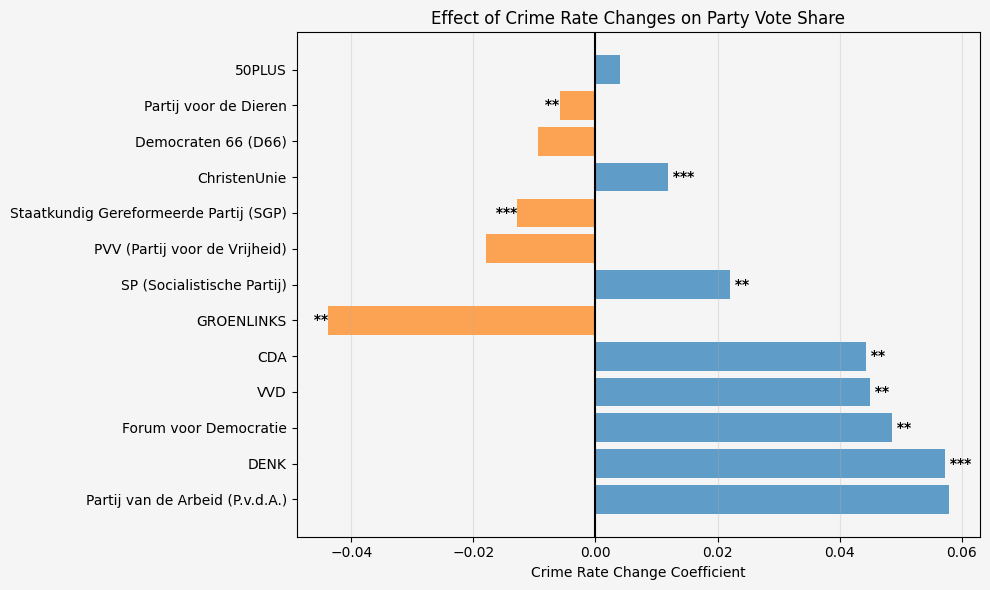

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot 1: Coefficient bar plot with confidence intervals
fig1, ax1 = plt.subplots(figsize=(10, 6))

colors = ['tab:orange' if x < 0 else 'tab:blue' for x in party_summary_abs['Coefficient']]
ax1.barh(range(len(party_summary_abs)), party_summary_abs['Coefficient'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(party_summary_abs)))
ax1.set_yticklabels(party_summary_abs['Party'])
ax1.axvline(x=0, color='black')
ax1.set_xlabel('Crime Rate Change Coefficient')
ax1.set_title('Effect of Crime Rate Changes on Party Vote Share')
ax1.grid(axis='x', alpha=0.3)

# Add significance markers
for idx, row in enumerate(party_summary_abs.itertuples()):
    if row.Significant:
        ax1.text(row.Coefficient, idx, f" {row.Significant}",
                va='center', ha='left' if row.Coefficient > 0 else 'right',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


## Code by Roy
Subquestion 2 work

"Do increases and decreases in crime affect voting behaviour symmetrically, or are voters more responsive to one direction of change?"

In [14]:
# Code by Roy — processing & modelling only
# This cell focuses purely on data preparation and estimation.
# All visualisation is handled in a separate cell.
# Prepare municipal-level panel (Roy-style format)
# ---------------------------------------------------------

# Create a working copy of the municipal voting dataset
votes_municipal_roy = panel_votes_municipal.copy()

# Rename columns to a consistent Dutch naming scheme
panel_votes_roy = votes_municipal_roy.rename(columns={
    'Region_Code': 'Code',
    'Region_Name': 'Gemeente',
    'Party': 'Partij',
    'Votes': 'AantalStemmen',
    'Year': 'Jaar',
    'Seats': 'AantalZetels',
    'Vote_Share': 'VoteShare',
})

# Create a working copy of the municipal crime dataset
crime_municipal_roy = panel_crime_municipal.copy()

# Rename crime-related columns to align with voting data
panel_crime_roy = crime_municipal_roy.rename(columns={
    'Region_Code': 'Code',
    'Year': 'Jaar',
    'Crime_Total': 'Crime_total',
    'Crime_Rate': 'Crime_rate',
    'Region_Name': 'Gemeente',
})

# Merge voting and crime data into a single panel
# Only municipality–year combinations present in both datasets are kept
panel = pd.merge(
    panel_votes_roy,
    panel_crime_roy,
    on=["Code", "Jaar", "Gemeente"],
    how="inner"
)



# Fixed effects model (levels) — VVD as example
# ---------------------------------------------------------

# Select observations for VVD only
vvd = panel[panel["Partij"] == "VVD"].copy()

# Set municipality and year as panel index
vvd = vvd.set_index(["Code", "Jaar"])

# Dependent variable: vote share
y = vvd["VoteShare"]

# Independent variable: crime rate (with intercept)
X = sm.add_constant(vvd[["Crime_rate"]])

# Two-way fixed effects model (municipality + year)
model = PanelOLS(y, X, entity_effects=True, time_effects=True)

# Estimate model with clustered standard errors at municipality level
results_vvd_fe = model.fit(cov_type="clustered", cluster_entity=True)


# National averages over time (used later for plotting)
# ---------------------------------------------------------

# Reset index to compute yearly aggregates
vvd_reset = vvd.reset_index()

# Compute average vote share and crime rate per year
vvd_year = (
    vvd_reset.groupby("Jaar", as_index=False)
             .agg(
                 mean_vote=("VoteShare", "mean"),
                 mean_crime=("Crime_rate", "mean")
             )
)



# Asymmetric fixed effects interaction model — VVD
# ---------------------------------------------------------

# Focus on VVD to illustrate asymmetric effects
party_name = "VVD"

# Sort by municipality and year to ensure correct differencing
df_vvd = panel[panel["Partij"] == party_name].copy().sort_values(["Code", "Jaar"])

# Compute within-municipality change in crime rate
df_vvd["Crime_diff"] = df_vvd.groupby("Code")["Crime_rate"].diff()

# Dummy indicating whether crime increased compared to the previous year
df_vvd["Crime_up_dummy"] = (df_vvd["Crime_diff"] > 0).astype(int)

# Interaction term to allow different effects for crime increases
df_vvd["Crime_diff_x_up"] = df_vvd["Crime_diff"] * df_vvd["Crime_up_dummy"]

# Set panel index for estimation
df_vvd = df_vvd.set_index(["Code", "Jaar"])

# Dependent and independent variables
y = df_vvd["VoteShare"]
X = sm.add_constant(df_vvd[["Crime_diff", "Crime_diff_x_up"]])

# Two-way fixed effects model with asymmetric interaction
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results_vvd_asym = model.fit(cov_type="clustered", cluster_entity=True)



# Prepare VVD data for later plotting (no plotting here)
# ---------------------------------------------------------

# Drop rows without crime changes or vote share values
plot_df_vvd = df_vvd.reset_index().dropna(subset=["Crime_diff", "VoteShare"]).copy()

# Demean vote share within municipalities to isolate within effects
plot_df_vvd["vote_within"] = (
    plot_df_vvd["VoteShare"]
    - plot_df_vvd.groupby("Code")["VoteShare"].transform("mean")
)

# Indicator for whether crime increased or decreased
plot_df_vvd["is_up"] = plot_df_vvd["Crime_diff"] > 0

# Store estimated coefficients for use in visualisation
beta1_vvd = results_vvd_asym.params.get("Crime_diff", 0.0)
beta2_vvd = results_vvd_asym.params.get("Crime_diff_x_up", 0.0)

# Remove a known extreme outlier to avoid distortion in plots
plot_df_vvd = plot_df_vvd.drop(
    plot_df_vvd[plot_df_vvd['Crime_diff'] == 130.4].index,
    errors='ignore'
)


# Asymmetric fixed effects interaction model — all parties
# ---------------------------------------------------------

results_list = []

# Loop over all parties in the dataset
for party in panel["Partij"].dropna().unique():
    tmp = panel[panel["Partij"] == party].copy().sort_values(["Code", "Jaar"])

    # Compute within-municipality crime change
    tmp["Crime_diff"] = tmp.groupby("Code")["Crime_rate"].diff()

    # Dummy for crime increases
    tmp["Crime_up_dummy"] = (tmp["Crime_diff"] > 0).astype(int)

    # Interaction term for asymmetric effect
    tmp["Crime_diff_x_up"] = tmp["Crime_diff"] * tmp["Crime_up_dummy"]

    # Remove incomplete observations
    tmp = tmp.dropna(subset=["Crime_diff", "VoteShare", "Crime_rate"]).copy()

    # Skip parties with too few observations for reliable estimation
    if len(tmp) < 50:
        continue

    # Set panel index
    tmp = tmp.set_index(["Code", "Jaar"])
    y_p = tmp["VoteShare"]
    X_p = sm.add_constant(tmp[["Crime_diff", "Crime_diff_x_up"]])

    try:
        # Estimate two-way fixed effects model
        model_p = PanelOLS(y_p, X_p, entity_effects=True, time_effects=True)
        res = model_p.fit(cov_type="clustered", cluster_entity=True)

        # Extract coefficients and p-value for asymmetry
        beta1 = float(res.params.get("Crime_diff", np.nan))
        beta2 = float(res.params.get("Crime_diff_x_up", np.nan))
        p_beta2 = res.pvalues.get("Crime_diff_x_up", np.nan)

        # Store results for comparison across parties
        results_list.append({
            "Party": party,
            "N_obs": int(res.nobs),
            "beta_decrease (β1)": beta1,
            "beta_increase (β1+β2)": beta1 + beta2,
            "beta2 (asymmetry)": beta2,
            "p_beta2": float(p_beta2) if pd.notnull(p_beta2) else np.nan
        })
    except Exception:
        # Skip parties where the model fails to converge
        continue

# Combine all party-level results into a single table
party_results = pd.DataFrame(results_list)



# Identify parties with statistically meaningful asymmetry
# ---------------------------------------------------------

# Select parties with significant and non-negligible asymmetric effects
key_parties = party_results[
    (party_results["p_beta2"] < 0.05) &
    (party_results["beta2 (asymmetry)"].abs() > 0.001)
]["Party"].tolist()


/home/kaai/uva/sda/SDA2025/.venv/lib/python3.12/site-packages/linearmodels/panel/model.py:1258: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


VVD FE (levels) summary:
                          PanelOLS Estimation Summary                           
Dep. Variable:              VoteShare   R-squared:                     1.829e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0006
No. Observations:                1858   R-squared (Within):              -0.0005
Date:                Sun, Dec 21 2025   R-squared (Overall):             -0.0002
Time:                        22:25:20   Log-likelihood                   -3797.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0026
Entities:                         448   P-value                           0.9596
Avg Obs:                       4.1473   Distribution:                  F(1,1405)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             0.0016
   

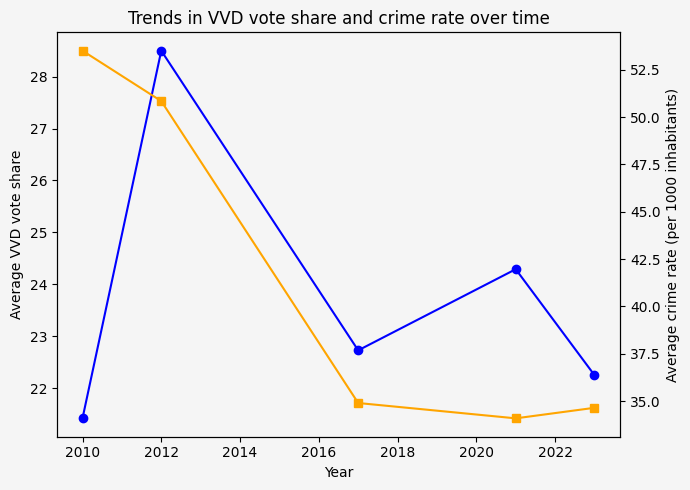

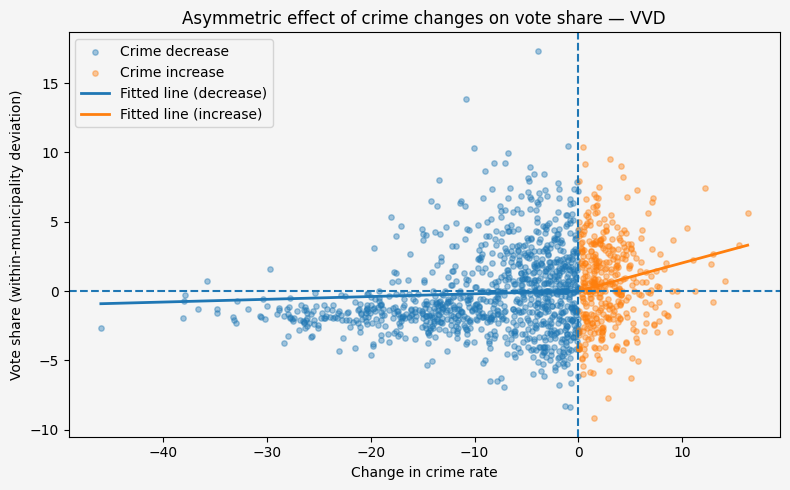

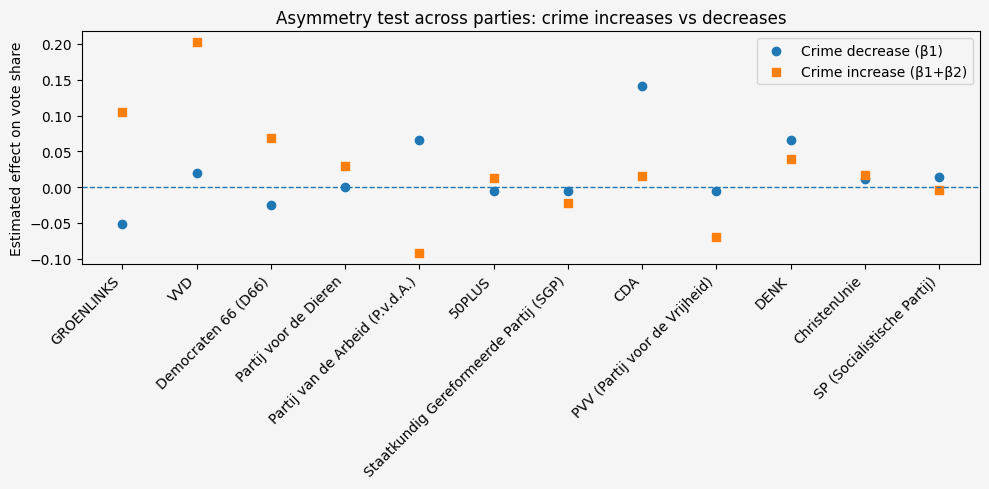

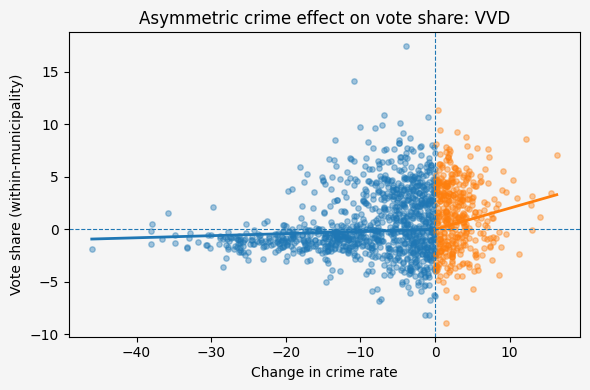

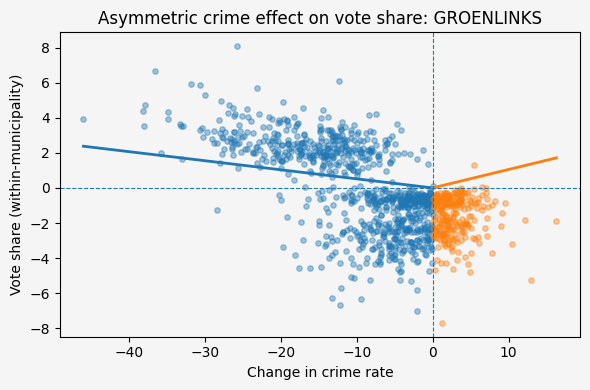

In [15]:
# Print summaries
print("VVD FE (levels) summary:")
print(results_vvd_fe.summary)

print("VVD FE interaction summary:")
print(results_vvd_asym.summary)

#National averages plot (VVD)
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.plot(vvd_year["Jaar"], vvd_year["mean_vote"], marker="o", color="blue")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average VVD vote share")

ax2 = ax1.twinx()
ax2.plot(vvd_year["Jaar"], vvd_year["mean_crime"], marker="s", color="orange")
ax2.set_ylabel("Average crime rate (per 1000 inhabitants)")

plt.title("Trends in VVD vote share and crime rate over time")
fig.tight_layout()
plt.show()

#VVD asymmetric scatter + fitted lines
x_min, x_max = plot_df_vvd["Crime_diff"].min(), plot_df_vvd["Crime_diff"].max()
x_down = np.linspace(x_min, 0, 50)
x_up = np.linspace(0, x_max, 50)

plt.figure(figsize=(8, 5))
plt.scatter(
    plot_df_vvd.loc[~plot_df_vvd["is_up"], "Crime_diff"],
    plot_df_vvd.loc[~plot_df_vvd["is_up"], "vote_within"],
    alpha=0.4, s=15, label="Crime decrease"
)
plt.scatter(
    plot_df_vvd.loc[plot_df_vvd["is_up"], "Crime_diff"],
    plot_df_vvd.loc[plot_df_vvd["is_up"], "vote_within"],
    alpha=0.4, s=15, label="Crime increase"
)
plt.plot(x_down, beta1_vvd * x_down, linewidth=2, label="Fitted line (decrease)")
plt.plot(x_up, (beta1_vvd + beta2_vvd) * x_up, linewidth=2, label="Fitted line (increase)")
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.xlabel("Change in crime rate")
plt.ylabel("Vote share (within-municipality deviation)")
plt.title("Asymmetric effect of crime changes on vote share — VVD")
plt.legend()
plt.tight_layout()
plt.show()

#Overview plot: asymmetric effects across parties
plot_res = (
    party_results[party_results["N_obs"] >= 200]
    .sort_values("p_beta2")
    .head(12)
)

if len(plot_res) > 0:
    x = np.arange(len(plot_res))
    plt.figure(figsize=(10, 5))
    plt.scatter(x, plot_res["beta_decrease (β1)"], marker="o", label="Crime decrease (β1)")
    plt.scatter(x, plot_res["beta_increase (β1+β2)"], marker="s", label="Crime increase (β1+β2)")
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xticks(x, plot_res["Party"], rotation=45, ha="right")
    plt.ylabel("Estimated effect on vote share")
    plt.title("Asymmetry test across parties: crime increases vs decreases")
    plt.legend()
    plt.tight_layout()
    plt.show()

#Individual plots for key parties
def plot_party_asymmetry(panel_df, party_name, results_df):
    dfp = panel_df[panel_df["Partij"] == party_name].copy().sort_values(["Code", "Jaar"])
    dfp["Crime_diff"] = dfp.groupby("Code")["Crime_rate"].diff()
    dfp["Crime_up"] = dfp["Crime_diff"] > 0
    dfp["vote_within"] = dfp["VoteShare"] - dfp.groupby("Code")["VoteShare"].transform("mean")
    dfp = dfp.dropna(subset=["Crime_diff", "vote_within"])

    beta1 = results_df.loc[results_df["Party"] == party_name, "beta_decrease (β1)"].values[0]
    beta_up = results_df.loc[results_df["Party"] == party_name, "beta_increase (β1+β2)"].values[0]

    if party_name == "VVD":
        dfp = dfp.drop(dfp[dfp['Crime_diff'] == 130.4].index, errors='ignore')

    x_min, x_max = dfp["Crime_diff"].min(), dfp["Crime_diff"].max()
    x_down = np.linspace(x_min, 0, 50)
    x_up = np.linspace(0, x_max, 50)

    plt.figure(figsize=(6, 4))
    plt.scatter(dfp.loc[~dfp["Crime_up"], "Crime_diff"], dfp.loc[~dfp["Crime_up"], "vote_within"], alpha=0.4, s=15)
    plt.scatter(dfp.loc[dfp["Crime_up"], "Crime_diff"], dfp.loc[dfp["Crime_up"], "vote_within"], alpha=0.4, s=15)
    plt.plot(x_down, beta1 * x_down, linewidth=2)
    plt.plot(x_up, beta_up * x_up, linewidth=2)
    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.axvline(0, linestyle="--", linewidth=0.8)
    plt.title(f"Asymmetric crime effect on vote share: {party_name}")
    plt.xlabel("Change in crime rate")
    plt.ylabel("Vote share (within-municipality)")
    plt.tight_layout()
    plt.show()

for p in key_parties:
    plot_party_asymmetry(panel, p, party_results)


## Code by Micah
Subquestion 3 work

"Is there a measurable association between regional voting patterns and crime levels, caused by spillover effects from neighbouring regions?"

In [16]:
"""
Parts of the spatial analysis pipeline, particularly the functions for year-level spatial model estimation and effect normalisation, 
were co-developed with the assistance of a large language model and subsequently reviewed, tested, and adapted by the author
"""


# Preconditions: ensure these processed tables are available
# These are assumed to be created in earlier notebook cells
if 'panel_crime_provincial' not in globals() or 'panel_votes_provincial' not in globals():
    raise RuntimeError("Please run cells that produce `panel_crime_provincial` and `panel_votes_provincial` before running this cell.")



# Data preparation
#---------------------------------------------------------

# Select and rename the relevant crime columns to a consistent schema
crime_long = panel_crime_provincial[['Region_Name', 'Year', 'Total_Crimes']].rename(
    columns={'Region_Name': 'Provincie', 'Year': 'Jaar', 'Total_Crimes': 'CrimeCount'}
)

# Pivot election data to wide format: one column per party
vote_wide = panel_votes_provincial.copy()
vote_wide = vote_wide.pivot_table(
    index=['Region_Name', 'Year'],
    columns='Party',
    values='Vote_Share',
    fill_value=0
).reset_index()

# Convert vote shares from percentages to proportions
party_columns = [c for c in vote_wide.columns if c not in ['Region_Name', 'Year']]
for c in party_columns:
    vote_wide[c] = vote_wide[c] / 100.0

# Align column names with the crime dataset
vote_wide = vote_wide.rename(columns={'Region_Name': 'Provincie', 'Year': 'Jaar'})

# Merge crime and voting data into a single panel-style dataset
data = vote_wide.merge(crime_long, on=['Provincie', 'Jaar'], how='left')


# Spatial structure: provinces and neighborhood relations
#---------------------------------------------------------

# Adjacency list describing which provinces share borders
# Used to construct the spatial weights matrix
neighbors = {
    "Groningen": ["Friesland", "Drenthe"],
    "Friesland": ["Groningen", "Drenthe", "Flevoland"],
    "Drenthe": ["Groningen", "Friesland", "Overijssel"],
    "Overijssel": ["Drenthe", "Flevoland", "Gelderland"],
    "Flevoland": ["Friesland", "Overijssel", "Gelderland", "Utrecht", "Noord-Holland"],
    "Gelderland": ["Overijssel", "Flevoland", "Utrecht", "Noord-Brabant", "Limburg"],
    "Utrecht": ["Flevoland", "Gelderland", "Noord-Holland", "Zuid-Holland", "Noord-Brabant"],
    "Noord-Holland": ["Flevoland", "Utrecht", "Zuid-Holland"],
    "Zuid-Holland": ["Noord-Holland", "Utrecht", "Zeeland", "Noord-Brabant"],
    "Zeeland": ["Zuid-Holland", "Noord-Brabant"],
    "Noord-Brabant": ["Zeeland", "Zuid-Holland", "Utrecht", "Gelderland", "Limburg"],
    "Limburg": ["Gelderland", "Noord-Brabant"]
}

# Fixed province ordering to ensure consistent alignment across matrices
provinces_ordered = [
    "Groningen", "Friesland", "Drenthe", "Overijssel", "Flevoland",
    "Gelderland", "Utrecht", "Noord-Holland", "Zuid-Holland",
    "Zeeland", "Noord-Brabant", "Limburg"
]

# Construct row-standardised spatial weights matrix
Wmat = W(neighbors, id_order=provinces_ordered)
Wmat.transform = "R"


# Helper utilities
#---------------------------------------------------------

# National election years used to compute inter-election changes
ELECTION_YEARS = [2010, 2012, 2017, 2021, 2023]

def previous_election(year):
    """
    Returns the previous national election year.
    Used to compute changes between elections.
    """
    idx = ELECTION_YEARS.index(year)
    return ELECTION_YEARS[idx - 1] if idx > 0 else None


# Year-level spatial model estimation

def analyze_year(year, data, vote_wide, Wmat, provinces_ordered, verbose=False):
    """
    For a given election year:
    computes crime change since the previous election,
    standardises crime change,
    estimates spatial lag (SLM) and spatial Durbin (SDM) models per party
    """

    Wmat.transform = 'R'
    prev = previous_election(year)
    if prev is None:
        raise ValueError(f"No previous election for year {year}")

    # Align crime counts for current and previous election years
    crime_now = data[data["Jaar"] == year].set_index("Provincie").reindex(provinces_ordered)
    crime_prev = data[data["Jaar"] == prev].set_index("Provincie").reindex(provinces_ordered)

    # Ensure numeric and handle missing values conservatively
    crime_now["CrimeCount"] = pd.to_numeric(crime_now["CrimeCount"], errors="coerce").fillna(crime_now["CrimeCount"].median())
    crime_prev["CrimeCount"] = pd.to_numeric(crime_prev["CrimeCount"], errors="coerce").fillna(crime_prev["CrimeCount"].median())

    # Compute inter-election crime change
    crime_change = (crime_now["CrimeCount"] - crime_prev["CrimeCount"]).values.reshape(-1, 1)

    # Prepare election-year voting data
    df = vote_wide[vote_wide["Jaar"] == year].set_index("Provincie").reindex(provinces_ordered).reset_index()

    # Standardise crime change for comparability across years
    df["CrimeChange"] = crime_change.flatten()
    df["CrimeChange"] = df["CrimeChange"].fillna(df["CrimeChange"].median())
    df["CrimeChange_std"] = (df["CrimeChange"] - df["CrimeChange"].mean()) / (
        df["CrimeChange"].std() if df["CrimeChange"].std() != 0 else 1
    )
    df["CrimeChange_std"] = df["CrimeChange_std"].fillna(0)

    # Identify parties with sufficient variation to estimate models
    party_columns = [p for p in vote_wide.columns if p not in ["Provincie", "Jaar"]]
    valid_parties = []
    for p in party_columns:
        if p in df.columns:
            y = pd.to_numeric(df[p], errors="coerce").fillna(0).values
            if np.isnan(y).any(): continue
            if np.var(y) == 0: continue
            if y.max() <= 0.001: continue
            valid_parties.append(p)

    # Design matrix and spatially lagged covariate
    X = df[["CrimeChange_std"]].values
    M_dense = np.array(Wmat.full()[0])
    WX = M_dense @ X

    # Avoid SDM when X and WX are nearly collinear
    corr_X_WX = np.corrcoef(X.flatten(), WX.flatten())[0, 1]
    allow_sdm = abs(corr_X_WX) < 0.95

    slm_results = {}
    sdm_results = {}

    # Estimate spatial models per party
    for party in valid_parties:
        y = df[party].values.reshape(-1, 1)
        try:
            slm = ML_Lag(
                y, X, w=Wmat,
                name_y=party,
                name_x=["CrimeChange_std"],
                name_w="W_provinces",
                name_ds=f"NL_{year}"
            )
            slm_results[party] = slm
        except Exception:
            if verbose:
                print("SLM failed for", party)
            continue

        if allow_sdm:
            try:
                sdm = GM_Lag(
                    y, X, w=Wmat,
                    name_y=party,
                    name_x=["CrimeChange_std"],
                    name_w="W_provinces",
                    name_ds=f"NL_{year}",
                    lag_q=1
                )
                sdm_results[party] = sdm
            except Exception:
                if verbose:
                    print("SDM failed for", party)
                continue

    return {
        "year": year,
        "previous_year": prev,
        "valid_parties": valid_parties,
        "slm": slm_results,
        "sdm": sdm_results
    }


# Spillover computation utilities
#---------------------------------------------------------

def regional_spillovers(year, data, Wmat, provinces_ordered):
    """
    Computes local and neighboring crime changes for descriptive analysis.
    """
    prev = previous_election(year)

    crime_now = data[data["Jaar"] == year].set_index("Provincie").reindex(provinces_ordered)
    crime_prev = data[data["Jaar"] == prev].set_index("Provincie").reindex(provinces_ordered)

    crime_now["CrimeCount"] = pd.to_numeric(crime_now["CrimeCount"], errors="coerce").fillna(0)
    crime_prev["CrimeCount"] = pd.to_numeric(crime_prev["CrimeCount"], errors="coerce").fillna(0)

    crime_change = (crime_now["CrimeCount"] - crime_prev["CrimeCount"]).values.reshape(-1, 1)
    W_dense = np.array(Wmat.full()[0])
    spill = W_dense @ crime_change

    return pd.DataFrame({
        "Province": provinces_ordered,
        "CrimeChange_Local": crime_change.flatten(),
        "CrimeChange_Spillover": spill.flatten()
    })


def compute_normalised_effects(year, data, vote_wide, Wmat, provinces_ordered, sdm_results):
    """
    Translates SDM coefficients into interpretable percentage-point vote effects.
    """
    if not sdm_results:
        return pd.DataFrame(columns=[
            "Province", "Party", "Crime_Local_%", "Crime_Spill_%",
            "Local_Vote_Effect_pp", "Spill_Vote_Effect_pp"
        ])

    prev = previous_election(year)

    crime_now = data[data["Jaar"] == year].set_index("Provincie").reindex(provinces_ordered)
    crime_prev = data[data["Jaar"] == prev].set_index("Provincie").reindex(provinces_ordered)

    # Percentage crime change relative to previous election
    crime_now_vals = pd.to_numeric(crime_now["CrimeCount"], errors="coerce").fillna(0)
    crime_prev_vals = pd.to_numeric(crime_prev["CrimeCount"], errors="coerce").replace(0, np.nan).fillna(1)
    crime_pct = ((crime_now_vals - crime_prev_vals) / crime_prev_vals * 100).values.reshape(-1, 1)

    # Spatially lagged crime change
    W_dense = np.array(Wmat.full()[0])
    spill_pct = W_dense @ crime_pct

    rows = []
    for party, model in sdm_results.items():
        try:
            beta = float(model.betas[1][0])
            theta = float(model.betas[2][0])
        except Exception:
            continue

        # Convert coefficients into vote share effects
        local_effect = (beta * crime_pct).flatten()
        spill_effect = (theta * spill_pct).flatten()

        rows.append(pd.DataFrame({
            "Province": provinces_ordered,
            "Party": party,
            "Crime_Local_%": crime_pct.flatten(),
            "Crime_Spill_%": spill_pct.flatten(),
            "Local_Vote_Effect_pp": local_effect,
            "Spill_Vote_Effect_pp": spill_effect
        }))

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


# Run analysis across election years
#---------------------------------------------------------

years_to_run = [2012, 2017, 2021, 2023]

results = {}
for y in years_to_run:
    results[y] = analyze_year(y, data, vote_wide, Wmat, provinces_ordered, verbose=False)

# Collect normalized spillover effects for later visualisation
effects = {}
all_impacts_frames = []

for y in years_to_run:
    res = results[y]
    effects_y = compute_normalised_effects(
        y, data, vote_wide, Wmat, provinces_ordered, res.get("sdm", {})
    )
    effects[y] = effects_y

    if not effects_y.empty:
        all_impacts_frames.append(effects_y.assign(Year=y))


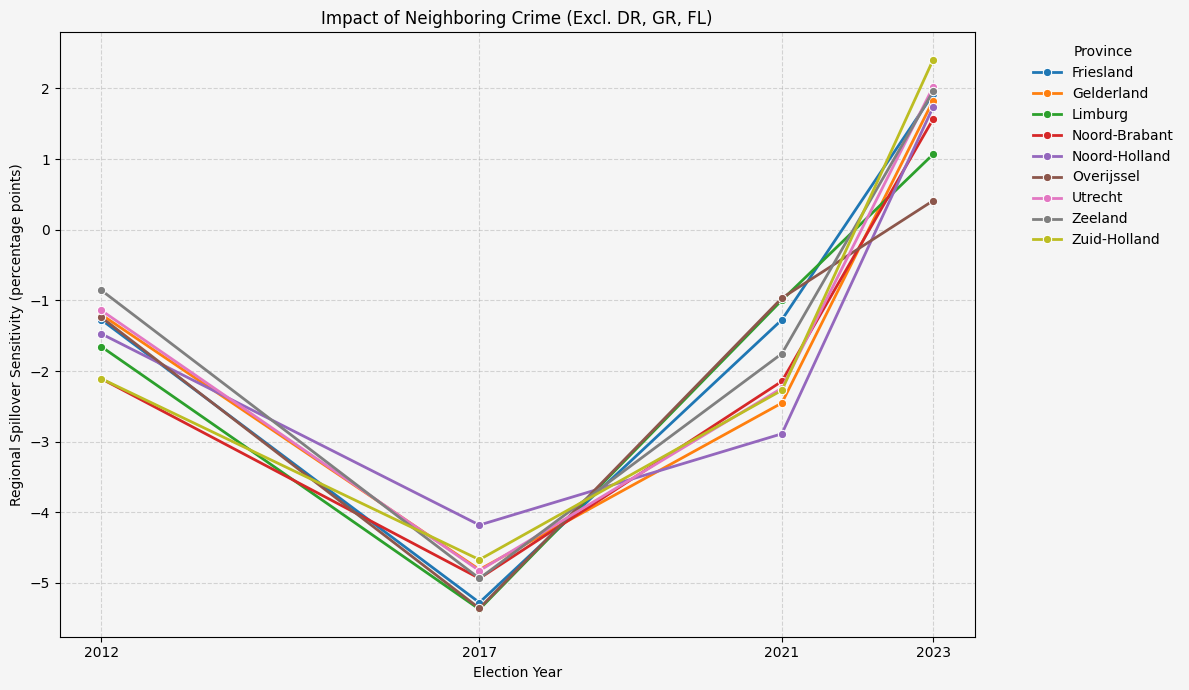

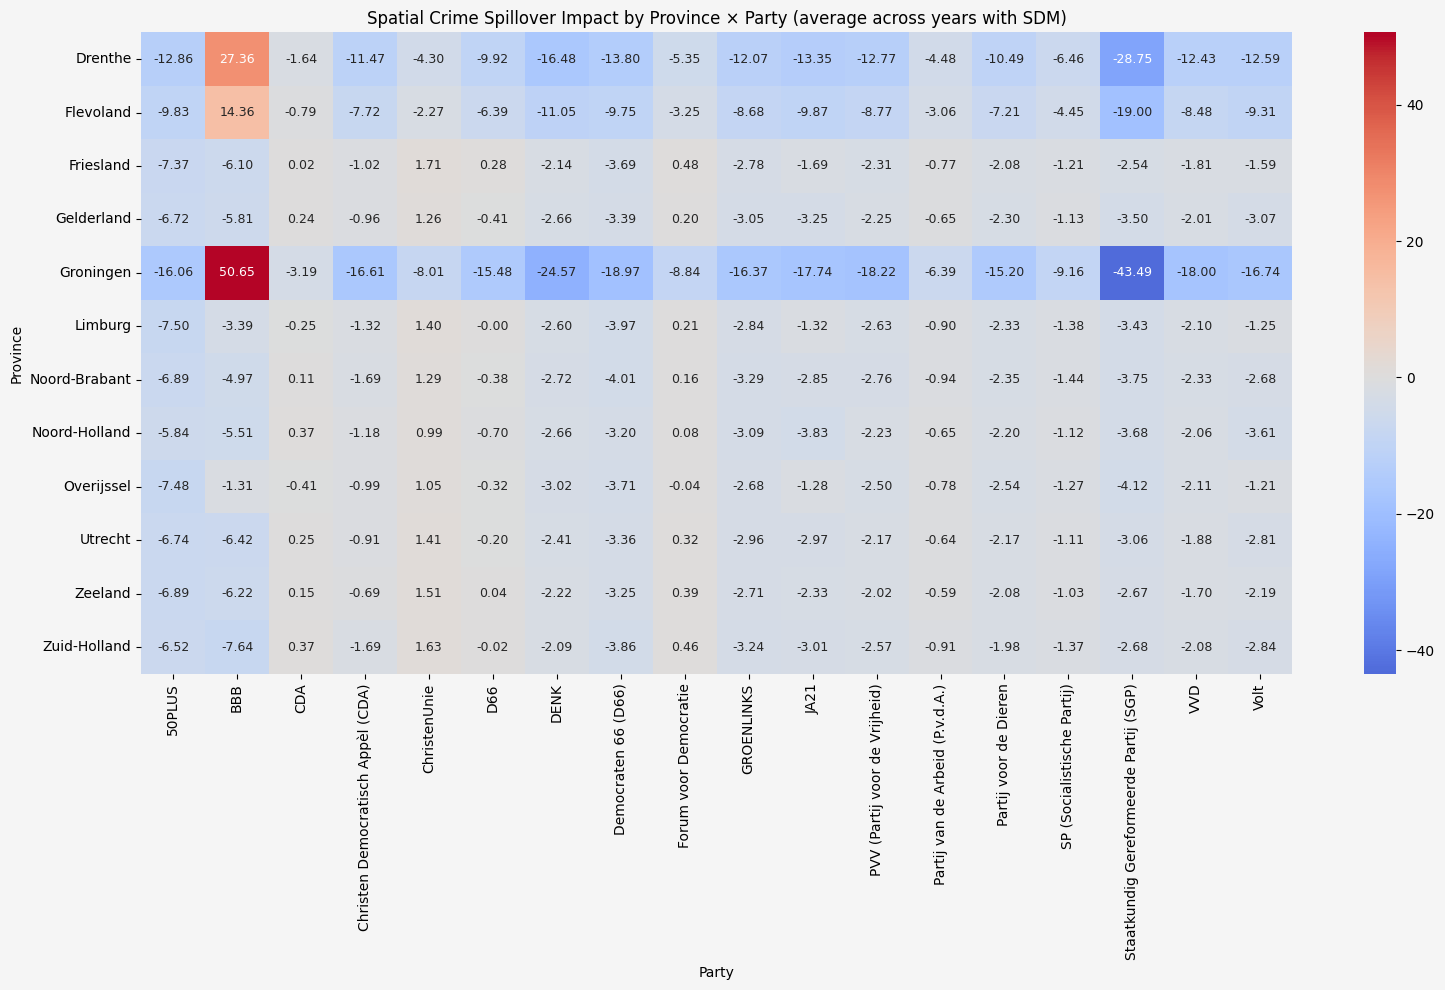


=== Aggregate Spatial Spillover Impact Report (SDM-based) ===

Average spillover vote effect by province (pp, mean across parties & years):
Province
Groningen       -14.9517
Drenthe         -10.3340
Flevoland        -7.0745
Noord-Brabant    -1.9790
Noord-Holland    -1.8430
Overijssel       -1.8372
Gelderland       -1.7996
Limburg          -1.7736
Zuid-Holland     -1.7477
Utrecht          -1.6822
Friesland        -1.5550
Zeeland          -1.5210

----------------------------------------------------------------------

Average spillover vote effect by party (pp, mean across provinces & years):
Party
Staatkundig Gereformeerde Partij (SGP)   -10.0551
50PLUS                                    -8.3926
Democraten 66 (D66)                       -6.2462
DENK                                      -6.2191
GROENLINKS                                -5.3139
JA21                                      -5.2921
PVV (Partij voor de Vrijheid)             -5.1005
Volt                                      -4.

In [17]:
# Line graph: province-level mean spillover effect across years (excluding a few provinces to reduce clutter)
if any(not df.empty for df in effects.values()):
    excluded = ["Drenthe", "Groningen", "Flevoland"]
    all_years_data=[]
    for year, df in effects.items():
        if df is None or df.empty:
            continue
        filtered = df[~df["Province"].isin(excluded)]
        year_avg = filtered.groupby("Province")["Spill_Vote_Effect_pp"].mean().reset_index()
        year_avg["Year"]=year
        all_years_data.append(year_avg)
    if all_years_data:
        plot_df = pd.concat(all_years_data, ignore_index=True)
        plt.figure(figsize=(12,7))
        sns.lineplot(data=plot_df, x="Year", y="Spill_Vote_Effect_pp", hue="Province", marker="o", palette="tab10", linewidth=2.0)
        plt.ylabel("Regional Spillover Sensitivity (percentage points)")
        plt.xlabel("Election Year")
        plt.title("Impact of Neighboring Crime (Excl. DR, GR, FL)")
        plt.legend(title="Province", bbox_to_anchor=(1.05,1), loc='upper left', frameon=False)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(sorted(plot_df["Year"].unique()))
        plt.tight_layout()
        plt.show()
    else:
        print("No plot data for line graph (all effects empty after exclusion).")
else:
    print("No SDM-based effects available for any year; skipping line plot.")

# Heatmap: Province × Party using concatenated impacts across years
if all_impacts_frames:
    all_impacts = pd.concat(all_impacts_frames, ignore_index=True)
    pivot = all_impacts.pivot_table(index="Province", columns="Party", values="Spill_Vote_Effect_pp", aggfunc='mean').fillna(0)
    plt.figure(figsize=(16,10))
    sns.heatmap(
        pivot,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 9}
        )
    

    plt.title("Spatial Crime Spillover Impact by Province × Party (average across years with SDM)")
    plt.tight_layout()
    plt.show()
else:
    print("No impact data available to build province×party heatmap (no SDM results produced).")



# This section summarises the average spatial crime spillover
# effect on vote shares by province and by party.
print("\n=== Aggregate Spatial Spillover Impact Report (SDM-based) ===\n")

#  Province-level average spillover effec
province_report = (
    all_impacts
    .groupby("Province")["Spill_Vote_Effect_pp"]
    .mean()
    .sort_values()
)

print("Average spillover vote effect by province (pp, mean across parties & years):")
print(province_report.to_string(float_format="%.4f"))

print("\n" + "-"*70 + "\n")

# Party-level average spillover effect
party_report = (
    all_impacts
    .groupby("Party")["Spill_Vote_Effect_pp"]
    .mean()
    .sort_values()
)

print("Average spillover vote effect by party (pp, mean across provinces & years):")
print(party_report.to_string(float_format="%.4f"))

print(
    "\nNote:\n"
    "- Values are expressed in percentage points of vote share.\n"
    "- Negative values indicate average vote losses associated with\n"
    "  increases in neighboring crime.\n"
    "- Positive values indicate average vote gains.\n"
)
